In [1]:
import gymnasium as gym
from gym_examples.envs.donation_env import DonationGameEnv
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
class QLearningAgent:
    def __init__(
        self,
        env: DonationGameEnv,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

        self.env = env

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    
    def halve_learning_rate(self):
        self.lr = self.lr / 2

In [3]:
def get_reward_func(reward_value, broke_punishment, saving_bonus, bonus_period):
    # Define reward functions
    def donation_reward(observation):
        player_val, bot_val, timestep = observation

        reward = 0
        if (bonus_period > 0 and timestep % bonus_period == 0):
            reward += player_val * saving_bonus 
            # print(f"apply saving bonus = {player_val * saving_bonus}")

        if player_val > 0:
            reward += reward_value[0]
        else:
            reward += broke_punishment
        
        if bot_val > 0:
            reward += reward_value[1]
        return reward
    
    return donation_reward

## Set training parameters

In [4]:
REWARD_MAP = { 
    "selfish": [1, 0],
    "white": [1, 0.08], 
    "latino": [1, 0.27],
    "altruistic": [1, 1],
}

In [5]:
""" Set game parameters here """
BROKE_PUNISHMENT = -1
SAVING_BONUS = 0
BONUS_PERIOD = 101

PLAYER_SALARY_OPTIONS = [5, 10, 15] 
ROBOT_SALARY_OPTIONS = [2]
PAY_PERIOD_OPTIONS = [6, 8, 10]
HORIZON = 100
EXPENSE_OPTIONS = [1, 1, 1, 1, 2]
DONATION_OPTIONS = [1]

In [6]:
""" Set training hyperparameters here """
learning_rate = 0.05
n_episodes = 100000
start_epsilon = 1
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

## Training

In [7]:
"""
Training code adopted from OpenAI gym documentation: 
https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/#sphx-glr-tutorials-training-agents-blackjack-tutorial-py
"""

def run_training(env, agent, n_episodes):
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        if episode % 50000 == 0:
            agent.halve_learning_rate()

        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            # update the agent
            agent.update(obs, action, reward, terminated, next_obs)

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()

def plot_training_process(env, agent):
    rolling_length = 500
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
    axs[0].set_title("Episode rewards")
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        np.convolve(
            np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

    axs[1].set_title("Training Error")
    training_error_moving_average = (
        np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
        / rolling_length
    )
    axs[1].plot(range(len(training_error_moving_average)), training_error_moving_average)
    plt.tight_layout()
    plt.show()

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [04:29<00:00, 370.96it/s]


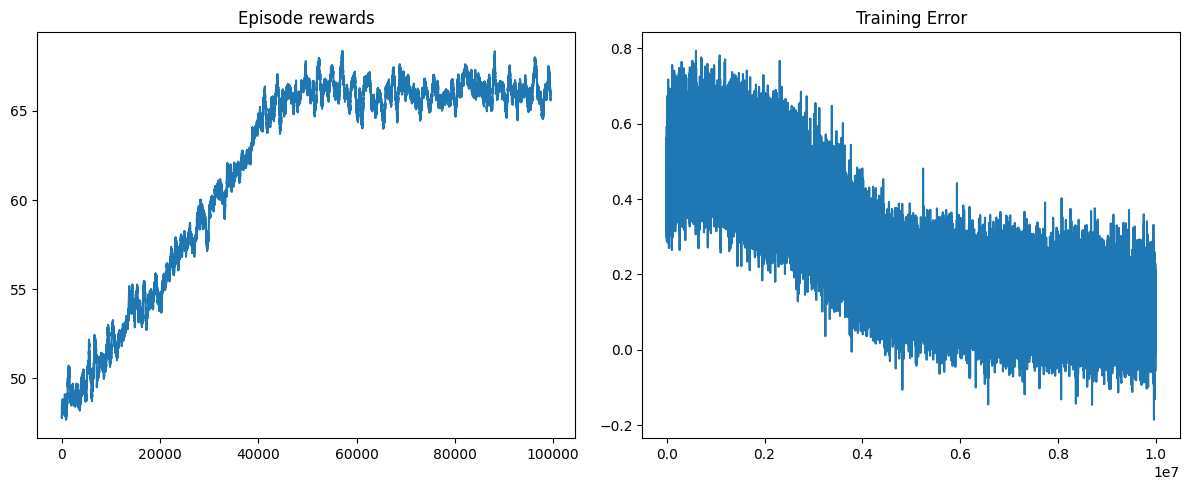

100%|██████████| 100000/100000 [04:08<00:00, 402.03it/s]


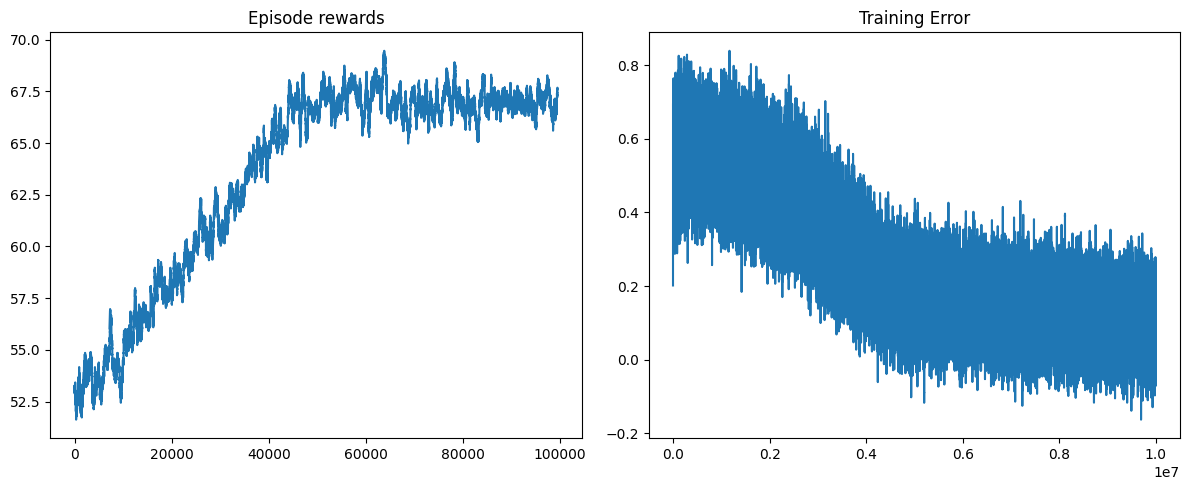

100%|██████████| 100000/100000 [04:00<00:00, 415.51it/s]


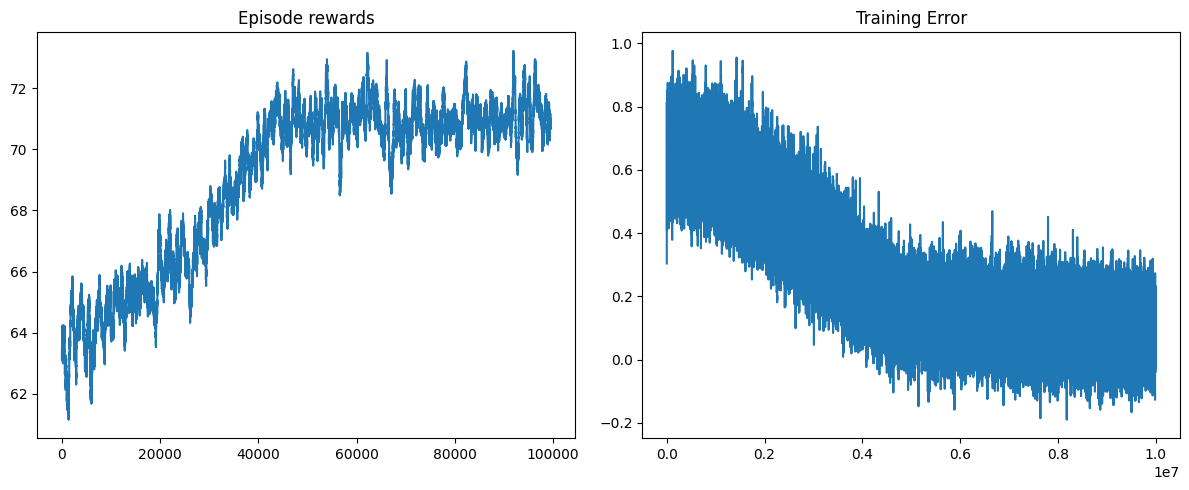

100%|██████████| 100000/100000 [03:59<00:00, 417.18it/s]


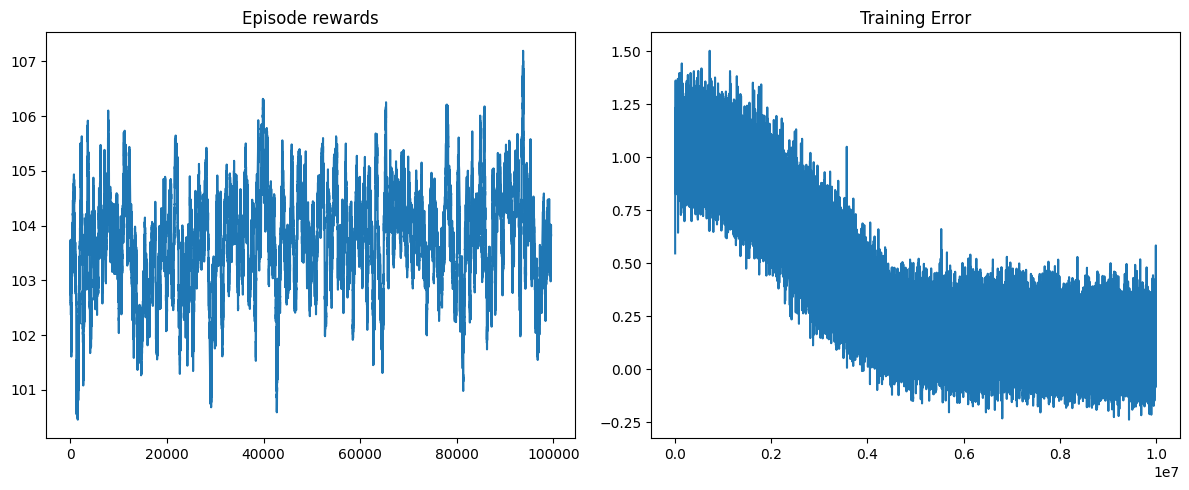

In [8]:
training_results = {}
for key in REWARD_MAP.keys():
    reward_pair = REWARD_MAP[key]
    reward_func = get_reward_func(reward_pair, BROKE_PUNISHMENT, SAVING_BONUS, BONUS_PERIOD)
    
    donation_game_env = DonationGameEnv(
            reward_func, 
            PLAYER_SALARY_OPTIONS, 
            ROBOT_SALARY_OPTIONS, 
            PAY_PERIOD_OPTIONS,
            HORIZON,
            EXPENSE_OPTIONS, 
            DONATION_OPTIONS
            )
    agent = QLearningAgent(
            env=donation_game_env,
            learning_rate=learning_rate,
            initial_epsilon=start_epsilon,
            epsilon_decay=epsilon_decay,
            final_epsilon=final_epsilon
            )

    env = gym.wrappers.RecordEpisodeStatistics(donation_game_env, deque_size=n_episodes)
    run_training(env, agent, n_episodes)
    plot_training_process(env, agent)

    training_results[key] = (donation_game_env, agent)

## Evaluation

In [24]:
def gather_game_rollout(game_env, agent, n_rounds):
    player_x_stats = []
    robot_y_stats = []
    actual_transfer_stat = []

    for i in range(0, n_rounds):
        obs, info = game_env.reset()
        done = False
        x_list = []
        y_list = []
        
        # play one episode
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = game_env.step(action)

            # update the agent
            agent.update(obs, action, reward, terminated, next_obs)

            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

            x_list.append(info["player_amount"])
            y_list.append(info["robot_amount"])

        player_x_stats.append(x_list)
        robot_y_stats.append(y_list)
        actual_transfer_stat.append(game_env.actual_transfer[1:])
    
    assert(len(player_x_stats) == n_rounds)
    assert(len(robot_y_stats) == n_rounds)
    assert(len(actual_transfer_stat) == n_rounds)
    return player_x_stats, robot_y_stats, actual_transfer_stat

def plot_amount_over_time(player_amount_stats, robot_amount_stats, actual_transfer_stat, title, greenDot, ylim=15):
    plt.figure(figsize=(10, 6))
    if type(player_amount_stats[0]) != list:
        player_amount_stats = [player_amount_stats]
        actual_transfer_stat = [actual_transfer_stat]
    
    # The actual share data is short by one, shifting the window for plotting.
    if len(actual_transfer_stat[0]) < 100:
        [play.append(0) for play in actual_transfer_stat]
    
    x_values = np.arange(1, len(player_amount_stats[0]) + 1)
    amount_means = np.mean(player_amount_stats, axis=0)
    # amount_std_devs = np.std(player_amount_stats, axis=0)
    transfer_means = np.mean(actual_transfer_stat, axis=0)
    # transfer_std_devs = np.std(actual_transfer_stat, axis=0)

    y_means = np.mean(robot_amount_stats, axis=0)

    # Plot points where the mean > 0 in one color
    sharing = transfer_means > 0
    keeping = transfer_means < 0
    
    plt.errorbar(x_values, amount_means, color="black", fmt='-', label="Agent's balance", linewidth=2)
    plt.errorbar(x_values[keeping], amount_means[keeping], color='#d62728', fmt='o', label='>50% keep' if len(player_amount_stats) > 1 else "Keep")
    plt.errorbar(x_values[sharing], amount_means[sharing], color='#1f77b4', fmt='o', label='>50% share' if len(player_amount_stats) > 1 else "Share")
    
    if np.max(y_means) > 0:
        if greenDot:
            plt.errorbar(x_values, y_means, color="gray", fmt='-', linewidth=2)
            plt.errorbar(x_values, y_means, color="green", fmt='o', label="Other agent's balance")
        else:
            plt.errorbar(x_values, y_means, color="gray", fmt='-', linewidth=2, label="Other agent's balance")


    # Change the font size of the tick labels beside the axes
    plt.tick_params(axis='both',  labelsize=11)  # For major ticks (x and y)

    plt.title(title, fontsize=14)
    plt.xlabel("Timestep", fontsize=12)
    plt.ylabel("Average balance", fontsize=12)
    plt.grid(True)
    plt.ylim(0, ylim)
    plt.legend(fontsize=11)
    plt.show()

def plot_cumulative_share_pattern(actual_transfer_stat):
    plt.figure(figsize=(10, 6))
    agent_colors = [
        ["altruistic", '#1f77b4'],
        ["latino", '#2ca02c'],
        ["white", '#ff7f0e'],
        ["selfish", '#d62728']
    ]
    for agent, color in agent_colors:
        stat = actual_transfer_stat[agent]
        # Calculate the cumulative sum
        cumulative_sum = [np.cumsum(play) for play in stat]

        cumulative_means = np.mean(cumulative_sum, axis=0)
        cumulative_std_devs = np.std(cumulative_sum, axis=0)

        # Plotting the cumulative sum
        plt.errorbar(np.arange(1, len(stat[0]) + 1), cumulative_means, yerr=cumulative_std_devs, 
                fmt='o', label=f'{agent}', color=color,
                # ecolor='lightblue', 
                elinewidth=1.5)
    
    # Change the font size of the tick labels beside the axes
    plt.tick_params(axis='both', labelsize=11)  # For major ticks (x and y)
    
    # plt.plot(cumulative_sum, marker='o', linestyle='-')
    plt.title(f'Sharing pattern over time for all agent', fontsize=14)
    plt.xlabel('Timestep', fontsize=12)
    plt.ylabel('Sharing pattern', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=11)
    plt.show()

def plot_effective_actions(transfer_results):
    labels = []
    give_std = []
    give_avg = []
    for agent_type in transfer_results:
        labels.append(agent_type)
        
        give_count = np.array([np.sum(np.array(play) > 0) for play in transfer_results[agent_type]])
        give_count_avg = np.mean(give_count)
        keep_count = np.array([np.sum(np.array(play) < 0) for play in transfer_results[agent_type]])
        keep_count_avg = np.mean(keep_count)
        
        print(f"{agent_type} give={give_count_avg} keep={keep_count_avg} share-keep ratio={give_count_avg / keep_count_avg}")
        give_avg.append(round(give_count_avg / (keep_count_avg + give_count_avg), 2))
        give_std.append(np.std(give_count / (keep_count + give_count)))
    

    plt.figure(figsize=(10, 6))

    # plt.errorbar(give_avg, labels, xerr=give_std, fmt='o', capsize=5, linestyle='None')
    # for xi, yi, label in zip(give_avg, np.arange(0, len(give_avg)), give_avg):
    #     plt.annotate(label, (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

    bars = plt.barh(labels, give_avg, height=0.4)

    # Add titles and labels
    plt.ylabel('IRL learned rewards', fontsize=12)
    plt.xlabel('Effective sharing rate', fontsize=12)
    plt.xlim(0, 1)
    plt.ylim(top=3.5)

    # Add data labels to the bars
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width()}', va='center', ha='left', fontsize=11)

    # Change the font size of the tick labels beside the axes
    plt.tick_params(axis='both',  labelsize=11)  # For major ticks (x and y)

    # Show the chart
    plt.show()

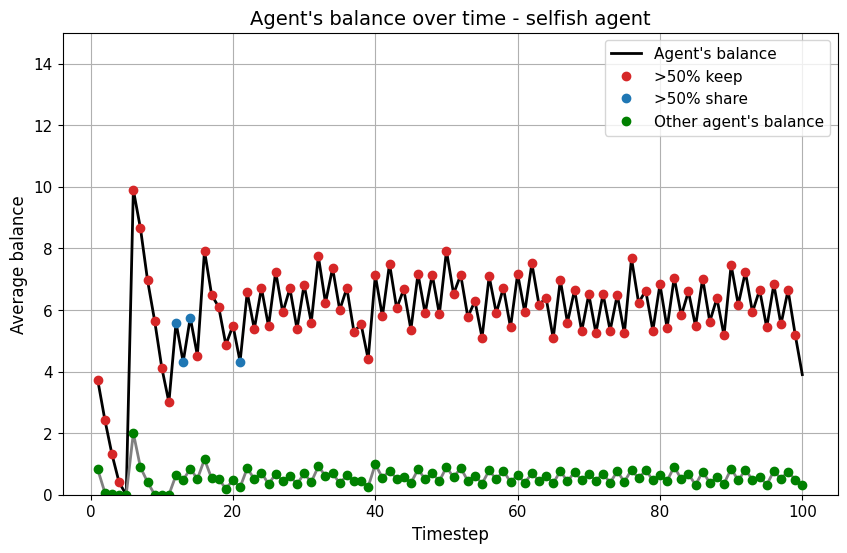

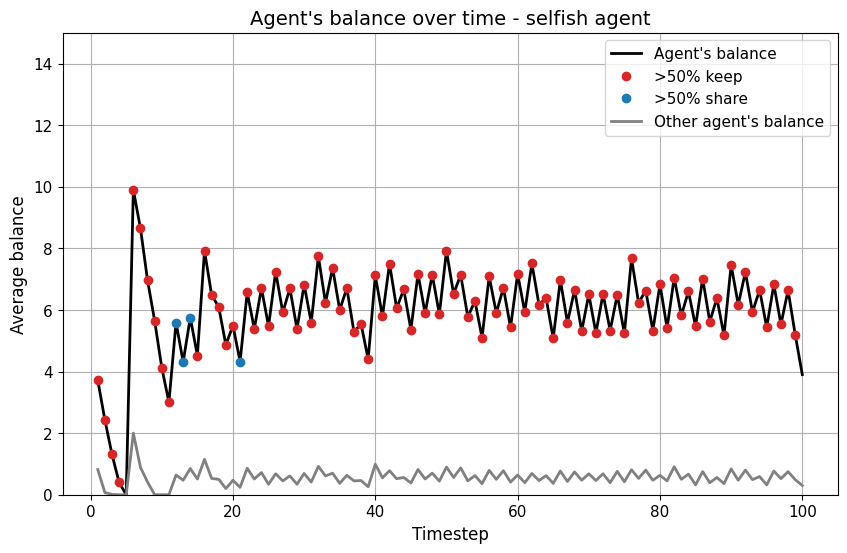

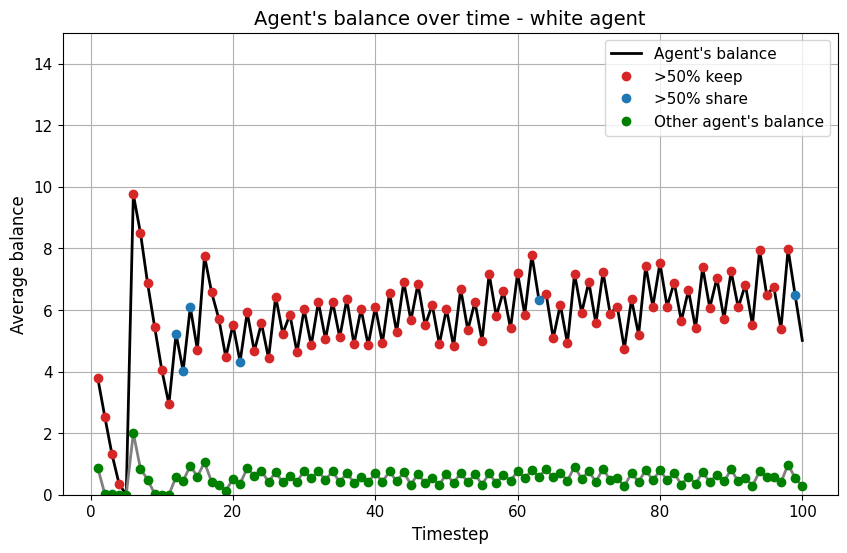

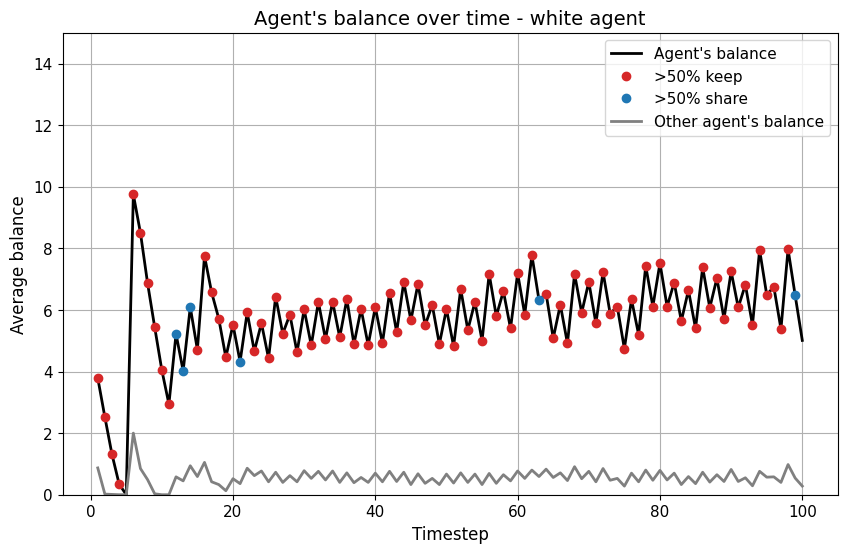

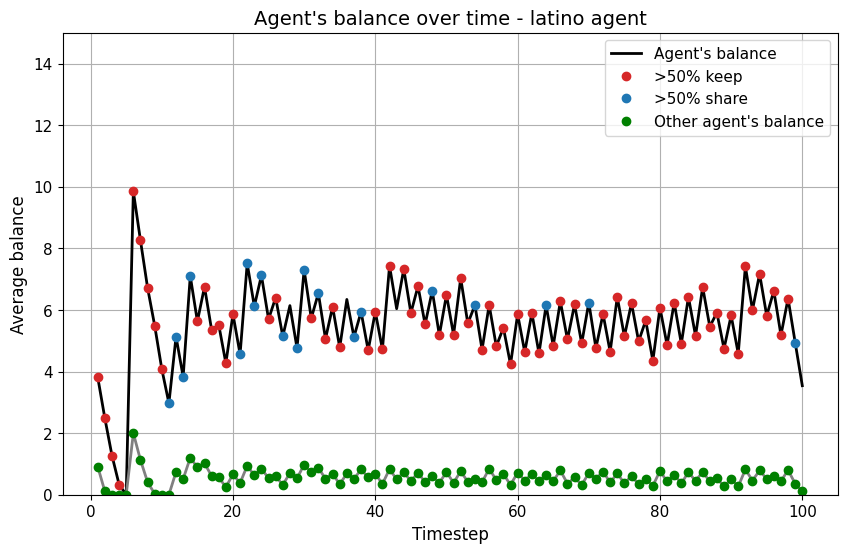

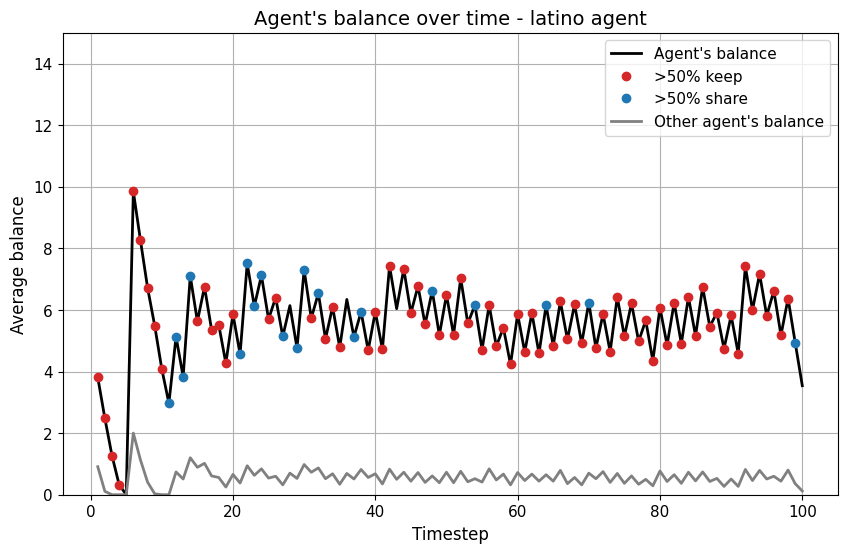

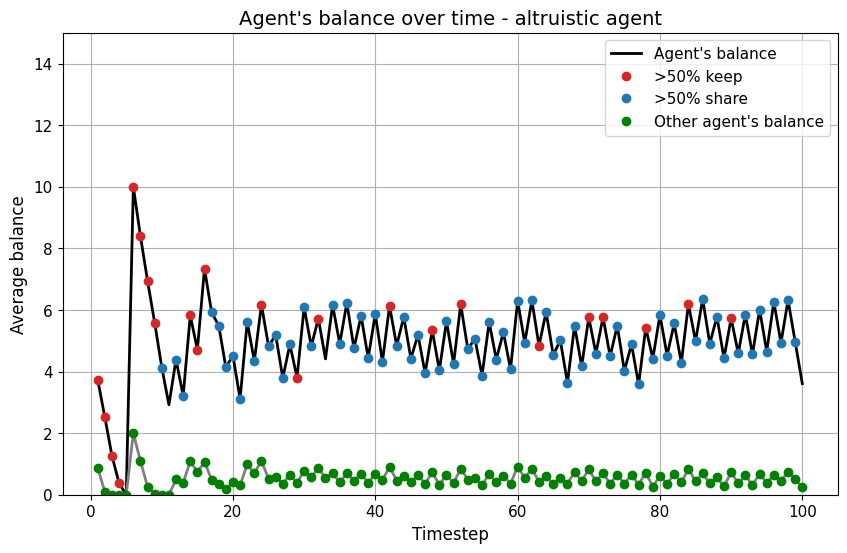

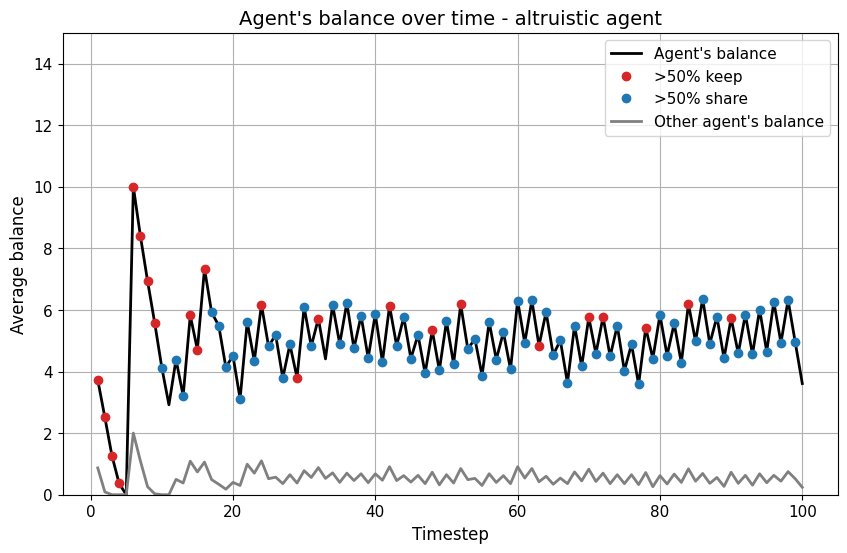

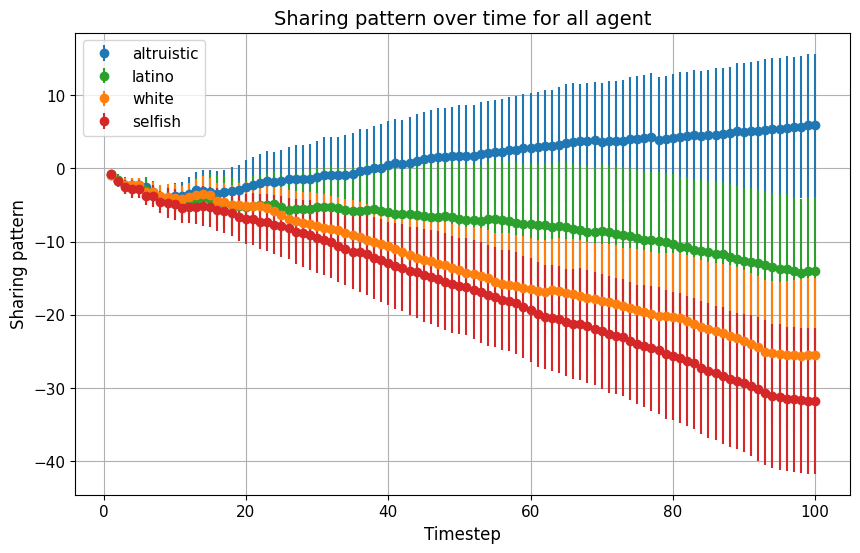

selfish give=23.81 keep=55.55 share-keep ratio=0.42862286228622865
white give=25.71 keep=51.27 share-keep ratio=0.5014628437682855
latino give=30.5 keep=44.58 share-keep ratio=0.6841633019291162
altruistic give=37.14 keep=31.27 share-keep ratio=1.1877198592900544


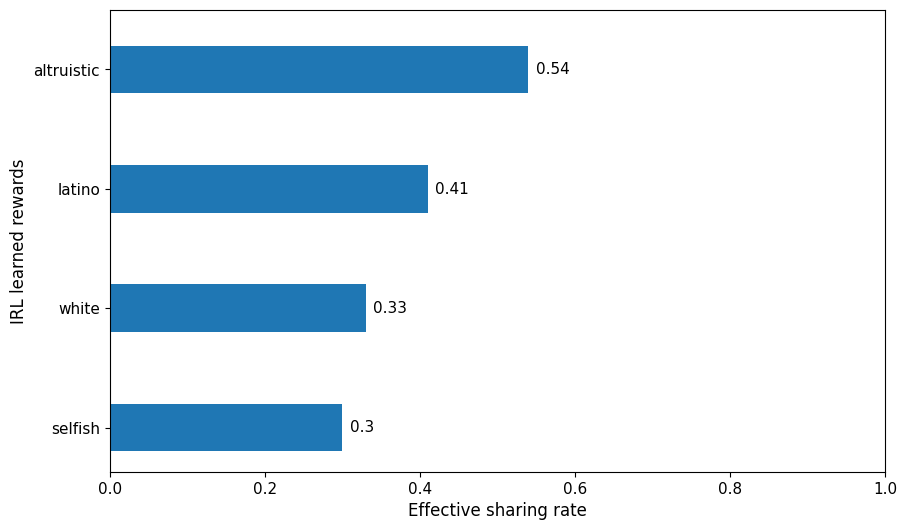

In [65]:
# Evaluate
transfer_patterns_by_agent = {}
for agent_type in REWARD_MAP:
    target_env, target_agent = training_results[agent_type]
    player_x_stats, robot_y_stats, actual_transfer_stat = gather_game_rollout(target_env, target_agent, 100)
    # actual_transfer_stat = [[p * -1 for p in play] for play in actual_transfer_stat]

    plot_amount_over_time(player_x_stats,robot_y_stats, actual_transfer_stat, f"Agent's balance over time - {agent_type} agent", True)
    plot_amount_over_time(player_x_stats,robot_y_stats, actual_transfer_stat, f"Agent's balance over time - {agent_type} agent", False)
    transfer_patterns_by_agent[agent_type] = actual_transfer_stat

plot_cumulative_share_pattern(transfer_patterns_by_agent)
plot_effective_actions(transfer_patterns_by_agent)

white give=28.0 keep=58.0 share-keep ratio=0.4827586206896552


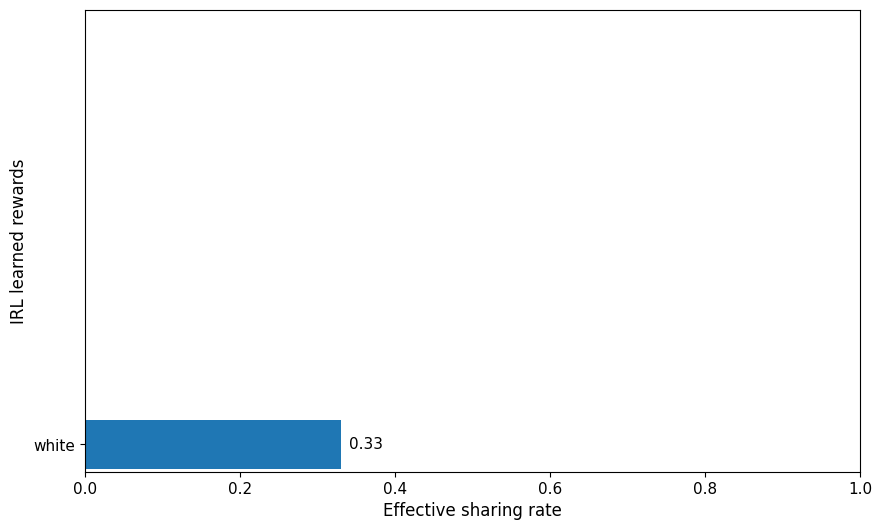

In [111]:
# Evaluate
transfer_patterns_by_agent = {}
agent_type = "white"

target_env, target_agent = training_results[agent_type]
player_x_stats, robot_y_stats, actual_transfer_stat = gather_game_rollout(target_env, target_agent, 1)
transfer_patterns_by_agent[agent_type] = actual_transfer_stat
plot_effective_actions(transfer_patterns_by_agent)


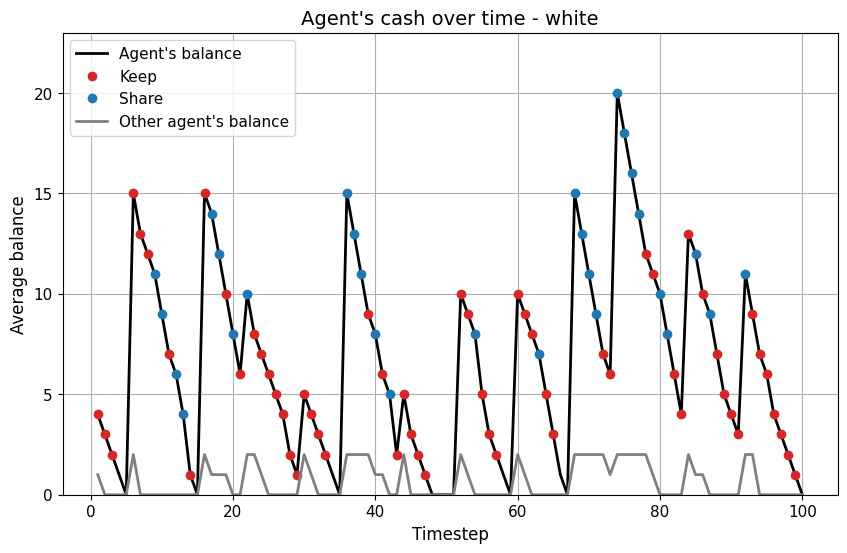

In [113]:

# plot_amount_over_time(player_x_stats, robot_y_stats, actual_transfer_stat, f"Agent's cash over time - {agent_type}", True, ylim=23)
plot_amount_over_time(player_x_stats, robot_y_stats, actual_transfer_stat, f"Agent's cash over time - {agent_type}", False, ylim=23)

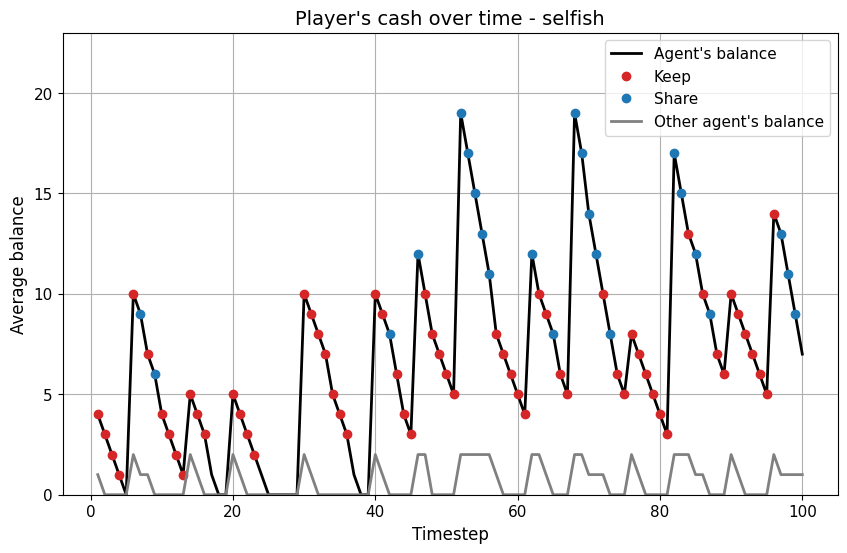

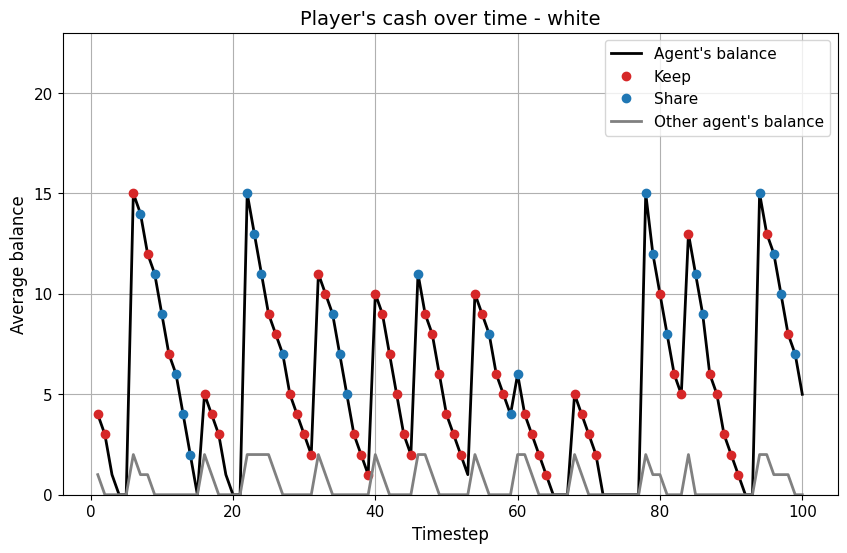

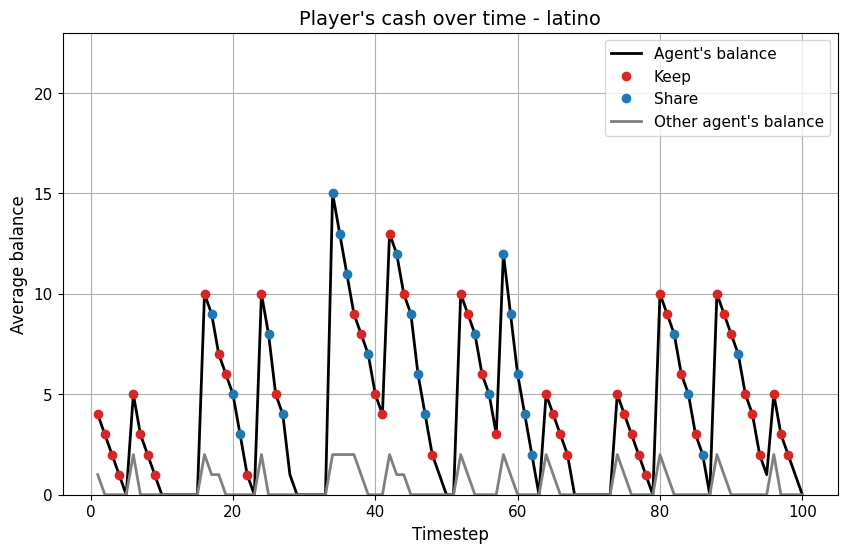

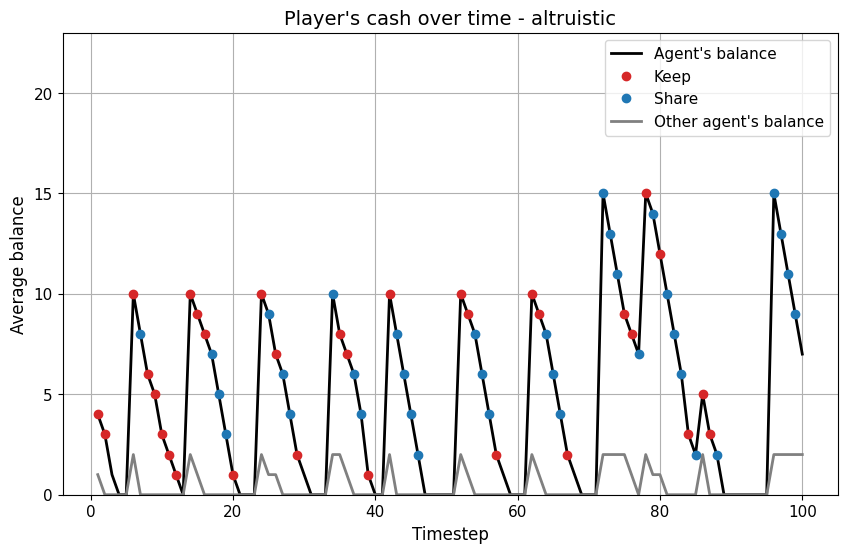

selfish give=23.0 keep=63.0 share-keep ratio=0.36507936507936506
white give=26.0 keep=54.0 share-keep ratio=0.48148148148148145
latino give=24.0 keep=47.0 share-keep ratio=0.5106382978723404
altruistic give=34.0 keep=32.0 share-keep ratio=1.0625


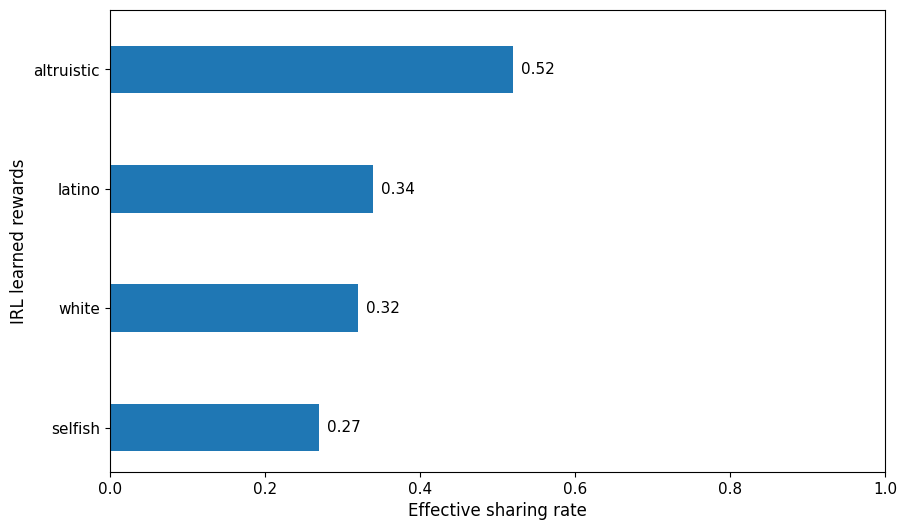

In [162]:
# Evaluate
transfer_patterns_by_agent = {}
for agent_type in training_results:
    target_env, target_agent = training_results[agent_type]
    player_x_stats, robot_y_stats, actual_transfer_stat = gather_game_rollout(target_env, target_agent, 1)

    # plot_amount_over_time(player_x_stats, robot_y_stats, actual_transfer_stat, f"Player's cash over time - {agent_type}", True, ylim=23)
    plot_amount_over_time(player_x_stats, robot_y_stats, actual_transfer_stat, f"Player's cash over time - {agent_type}", False, ylim=23)
    transfer_patterns_by_agent[agent_type] = actual_transfer_stat

plot_effective_actions(transfer_patterns_by_agent)

In [12]:
for agent in training_results:
    print(training_results[agent])

(<gym_examples.envs.donation_env.DonationGameEnv object at 0x7fd600f6f670>, <__main__.QLearningAgent object at 0x7fd5e0728760>)
(<gym_examples.envs.donation_env.DonationGameEnv object at 0x7fd5c0981b20>, <__main__.QLearningAgent object at 0x7fd5ed6bf040>)
(<gym_examples.envs.donation_env.DonationGameEnv object at 0x7fd580036d60>, <__main__.QLearningAgent object at 0x7fd5a21051c0>)
(<gym_examples.envs.donation_env.DonationGameEnv object at 0x7fd5812849d0>, <__main__.QLearningAgent object at 0x7fd5e072f730>)


In [13]:
"""
BROKE_PUNISHMENT = -1
SAVING_BONUS = 1
BONUS_PERIOD = 50

REWARD_FUNC = get_reward_func(REWARD_PAIR, BROKE_PUNISHMENT, SAVING_BONUS, BONUS_PERIOD)
PLAYER_SALARY_OPTIONS = [5, 10, 15] 
ROBOT_SALARY_OPTIONS = [0]
PAY_PERIOD_OPTIONS = [6, 8, 10]
HORIZON = 100
EXPENSE_OPTIONS = [1, 1, 1, 1, 2]
DONATION_OPTIONS = [1]

Altruistic:
'give_count': 62, 'keep_count': 38

Latino:
'give_count': 44, 'keep_count': 56

White:
'give_count': 38, 'keep_count': 62

Selfish:
'give_count': 32, 'keep_count': 68,
"""

"\nBROKE_PUNISHMENT = -1\nSAVING_BONUS = 1\nBONUS_PERIOD = 50\n\nREWARD_FUNC = get_reward_func(REWARD_PAIR, BROKE_PUNISHMENT, SAVING_BONUS, BONUS_PERIOD)\nPLAYER_SALARY_OPTIONS = [5, 10, 15] \nROBOT_SALARY_OPTIONS = [0]\nPAY_PERIOD_OPTIONS = [6, 8, 10]\nHORIZON = 100\nEXPENSE_OPTIONS = [1, 1, 1, 1, 2]\nDONATION_OPTIONS = [1]\n\nAltruistic:\n'give_count': 62, 'keep_count': 38\n\nLatino:\n'give_count': 44, 'keep_count': 56\n\nWhite:\n'give_count': 38, 'keep_count': 62\n\nSelfish:\n'give_count': 32, 'keep_count': 68,\n"

In [14]:
"""
BROKE_PUNISHMENT = 0
SAVING_BONUS = 0.1
BONUS_PERIOD = 20

REWARD_FUNC = get_reward_func(REWARD_PAIR, BROKE_PUNISHMENT, SAVING_BONUS, BONUS_PERIOD)
PLAYER_SALARY_OPTIONS = [5, 10, 15] 
ROBOT_SALARY_OPTIONS = [0]
PAY_PERIOD_OPTIONS = [6, 8, 10]
HORIZON = 100
EXPENSE_OPTIONS = [1, 1, 1, 1, 2]
DONATION_OPTIONS = [1]

Altruistic:
'give_count': 72, 'keep_count': 28

Latino:
'give_count': 55, 'keep_count': 45,

White:
'give_count': 45, 'keep_count': 55

Selfish:
'give_count': 36, 'keep_count': 64
"""

"\nBROKE_PUNISHMENT = 0\nSAVING_BONUS = 0.1\nBONUS_PERIOD = 20\n\nREWARD_FUNC = get_reward_func(REWARD_PAIR, BROKE_PUNISHMENT, SAVING_BONUS, BONUS_PERIOD)\nPLAYER_SALARY_OPTIONS = [5, 10, 15] \nROBOT_SALARY_OPTIONS = [0]\nPAY_PERIOD_OPTIONS = [6, 8, 10]\nHORIZON = 100\nEXPENSE_OPTIONS = [1, 1, 1, 1, 2]\nDONATION_OPTIONS = [1]\n\nAltruistic:\n'give_count': 72, 'keep_count': 28\n\nLatino:\n'give_count': 55, 'keep_count': 45,\n\nWhite:\n'give_count': 45, 'keep_count': 55\n\nSelfish:\n'give_count': 36, 'keep_count': 64\n"

In [15]:
"""
REWARD_PAIR = REWARD_MAP["altruistic"]
BROKE_PUNISHMENT = 0
SAVING_BONUS = 0.1
BONUS_PERIOD = 100

REWARD_FUNC = get_reward_func(REWARD_PAIR, BROKE_PUNISHMENT, SAVING_BONUS, BONUS_PERIOD)
PLAYER_SALARY_OPTIONS = [5, 10, 15] 
ROBOT_SALARY_OPTIONS = [0]
PAY_PERIOD_OPTIONS = [6, 8, 10]
HORIZON = 100
EXPENSE_OPTIONS = [1, 1, 1, 1, 2]
DONATION_OPTIONS = [1]

Altruistic:
'give_count': 74, 'keep_count': 26

Latino:
'give_count': 52, 'keep_count': 48

White:
'give_count': 44, 'keep_count': 56

Selfish
'give_count': 40, 'keep_count': 60

"""

'\nREWARD_PAIR = REWARD_MAP["altruistic"]\nBROKE_PUNISHMENT = 0\nSAVING_BONUS = 0.1\nBONUS_PERIOD = 100\n\nREWARD_FUNC = get_reward_func(REWARD_PAIR, BROKE_PUNISHMENT, SAVING_BONUS, BONUS_PERIOD)\nPLAYER_SALARY_OPTIONS = [5, 10, 15] \nROBOT_SALARY_OPTIONS = [0]\nPAY_PERIOD_OPTIONS = [6, 8, 10]\nHORIZON = 100\nEXPENSE_OPTIONS = [1, 1, 1, 1, 2]\nDONATION_OPTIONS = [1]\n\nAltruistic:\n\'give_count\': 74, \'keep_count\': 26\n\nLatino:\n\'give_count\': 52, \'keep_count\': 48\n\nWhite:\n\'give_count\': 44, \'keep_count\': 56\n\nSelfish\n\'give_count\': 40, \'keep_count\': 60\n\n'

In [16]:
"""
REWARD_PAIR = REWARD_MAP["latino"]
BROKE_PUNISHMENT = 0
SAVING_BONUS = 0
BONUS_PERIOD = 0

REWARD_FUNC = get_reward_func(REWARD_PAIR, BROKE_PUNISHMENT, SAVING_BONUS, BONUS_PERIOD)
PLAYER_SALARY_OPTIONS = [5, 10, 15] 
ROBOT_SALARY_OPTIONS = [2, 3, 4]
PAY_PERIOD_OPTIONS = [6, 8, 10]
HORIZON = 100
EXPENSE_OPTIONS = [1, 1, 1, 2]
DONATION_OPTIONS = [1]

Selfish:
    'give_count': 46, 'keep_count': 54

Altruistic:
    'give_count': 61
    

"""

'\nREWARD_PAIR = REWARD_MAP["latino"]\nBROKE_PUNISHMENT = 0\nSAVING_BONUS = 0\nBONUS_PERIOD = 0\n\nREWARD_FUNC = get_reward_func(REWARD_PAIR, BROKE_PUNISHMENT, SAVING_BONUS, BONUS_PERIOD)\nPLAYER_SALARY_OPTIONS = [5, 10, 15] \nROBOT_SALARY_OPTIONS = [2, 3, 4]\nPAY_PERIOD_OPTIONS = [6, 8, 10]\nHORIZON = 100\nEXPENSE_OPTIONS = [1, 1, 1, 2]\nDONATION_OPTIONS = [1]\n\nSelfish:\n    \'give_count\': 46, \'keep_count\': 54\n\nAltruistic:\n    \'give_count\': 61\n    \n\n'

In [17]:
"""
REWARD_PAIR = REWARD_MAP["selfish"]
BROKE_PUNISHMENT = 0
SAVING_BONUS = 0
BONUS_PERIOD = 0

REWARD_FUNC = get_reward_func(REWARD_PAIR, BROKE_PUNISHMENT, SAVING_BONUS, BONUS_PERIOD)
PLAYER_SALARY_OPTIONS = [15] 
ROBOT_SALARY_OPTIONS = [0]
PAY_PERIOD_OPTIONS = [10]
HORIZON = 100
EXPENSE_OPTIONS = [1, 1, 1, 2]
DONATION_OPTIONS = [1]

Selfish:
    'give_count' = 23, 
    'keep_count' = 77
    X = [13,11,9,8,6,4,2,1,0,15,14,13,12,11,10,8,7,5,4,16,15,14,11,10,8,6,5,4,3,17,15,14,13,11,10,8,7,5,3,17,15,14,13,11,10,8,7,5,3,16,15,14,13,11,9,8,6,5,3,17,16,14,12,11,10,8,6,5,4,17,15,13,12,11,10,9,6,5,4,17,16,15,13,12,9,8,6,5,4,17,16,15,12,10,9,8,6,5,3,2]
    transfer = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1]

White:
    'give_count' = 35
    'keep_count' = 65
    X = [13,12,11,9,7,6,5,4,2,15,14,12,11,9,7,6,5,4,2,15,13,12,11,10,9,6,4,3,2,15,13,12,11,10,9,8,6,4,1,15,14,11,10,9,8,6,5,4,2,15,13,12,10,9,8,7,6,4,2,15,14,12,11,9,8,7,6,4,1,15,12,10,9,8,6,5,4,3,2,15,13,12,11,9,8,7,6,4,2,15,13,12,11,10,9,6,5,4,1,0]
    transfer = [-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1]
    
Latino:
    'give_count': 38
    'keep_count': 62
    X = [13,12,10,9,8,6,5,4,2,15,13,12,10,9,7,5,3,2,0,15,14,12,10,9,7,5,3,2,1,15,13,11,10,9,7,5,4,3,2,15,13,12,10,9,8,6,5,4,2,15,13,11,10,8,7,5,4,2,1,15,12,11,10,8,7,6,5,4,2,15,13,11,10,8,7,6,5,3,2,15,13,12,10,9,8,6,5,4,2,15,13,11,10,9,7,5,4,3,2,0]
    transfer = [1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 0, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 0, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1]
    
Altruistic: 
    'give_count': 72
    'keep_count': 28
    X = [13,11,9,7,5,3,1,0,0,15,13,11,8,6,4,2,0,0,0,15,13,11,9,7,5,3,0,0,0,15,13,10,7,5,4,2,0,0,0,15,12,9,6,4,2,0,0,0,0,15,14,12,10,9,7,5,3,1,0,15,13,10,8,6,4,2,0,0,0,15,13,11,10,9,7,5,3,1,0,15,13,10,9,7,5,2,0,0,0,15,12,10,7,5,3,1,0,0,0,0]
    transfer = [1, 1, 1, 1, 1, 1, 1, 0, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 0, -1, 1, 1, 1, 1, 1, 1, 1, 0, -1, -1, 1, 1, 1, -1, -1, 1, 1, 0, 0, -1, 1, 1, 1, 1, -1, -1, 0, -1, 0, 0, -1, 1, 1, -1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 0, 1, 1, 1, 1, 1, 1, 0, -1, -1, -1]

    
"""

'\nREWARD_PAIR = REWARD_MAP["selfish"]\nBROKE_PUNISHMENT = 0\nSAVING_BONUS = 0\nBONUS_PERIOD = 0\n\nREWARD_FUNC = get_reward_func(REWARD_PAIR, BROKE_PUNISHMENT, SAVING_BONUS, BONUS_PERIOD)\nPLAYER_SALARY_OPTIONS = [15] \nROBOT_SALARY_OPTIONS = [0]\nPAY_PERIOD_OPTIONS = [10]\nHORIZON = 100\nEXPENSE_OPTIONS = [1, 1, 1, 2]\nDONATION_OPTIONS = [1]\n\nSelfish:\n    \'give_count\' = 23, \n    \'keep_count\' = 77\n    X = [13,11,9,8,6,4,2,1,0,15,14,13,12,11,10,8,7,5,4,16,15,14,11,10,8,6,5,4,3,17,15,14,13,11,10,8,7,5,3,17,15,14,13,11,10,8,7,5,3,16,15,14,13,11,9,8,6,5,3,17,16,14,12,11,10,8,6,5,4,17,15,13,12,11,10,9,6,5,4,17,16,15,13,12,9,8,6,5,4,17,16,15,12,10,9,8,6,5,3,2]\n    transfer = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1

## Setup 3

PLAYER_SALARY = 15
ROBOT_SALARY = 0
PAY_PERIOD = 10
HORIZON = 100
DOUBLE_PERCENTAGE = 0.5

## double = 50%
selfish: give_count': 13, 'keep_count': 87
altruistic: 'give_count': 62, 'keep_count': 38

## Setup 3.1
PLAYER_SALARY = 15
ROBOT_SALARY = 0
PAY_PERIOD = 10
HORIZON = 100
DOUBLE_PERCENTAGE = 0.25

## double = 25%
selfish: 'give_count': 33, 'keep_count': 67
X='13,11,10,9,8,6,5,3,17,14,12,10,7,5,3,1,0,0,15,13,11,10,8,6,4,3,2,1,15,13,11,10,9,7,6,5,4,3,17,14,12,10,9,8,6,4,3,2,15,14,12,10,9,7,6,5,4,2,16,15,14,13,12,10,7,5,4,2,16,13,11,9,7,5,3,1,0,0,15,14,12,10,9,7,5,4,3,1,15,14,12,11,9,8,7,5,3,1,15,13'
donation=[0, 0, 0, 0, 0, 1, 2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 17, 18, 18, 19, 19, 19, 19, 19, 20, 21, 22, 22, 22, 22, 22, 22, 23, 23, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 27, 28, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 31]


white: 'give_count': 39, 'keep_count': 61
'14,13,12,11,10,9,7,5,18,16,14,11,9,8,6,4,1,0,15,14,12,11,10,8,6,3,1,0,15,13,12,10,9,8,5,3,1,0,15,14,13,12,11,9,7,6,4,2,16,14,13,12,10,9,8,6,4,2,15,14,12,11,10,9,8,7,6,4,17,14,13,12,10,9,8,6,4,2,16,14,13,12,10,9,7,6,4,1,15,14,12,11,10,8,6,3,2,1,15,13'
[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 5, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 15, 15, 16, 16, 16, 16, 16, 16, 17, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 21, 22, 22, 22, 23, 23, 23, 24, 25, 26, 26, 27, 27, 27, 27, 27, 27, 27, 28, 29, 29, 29, 30, 30, 30, 30, 31, 32, 32, 32, 32, 32]

latino: 'give_count': 67, 'keep_count': 33
14,12,9,7,5,2,0,0,15,13,11,9,7,5,2,0,0,0,15,13,11,8,6,4,2,0,0,0,15,14,12,9,7,5,3,1,0,0,15,14,11,9,7,5,3,1,0,0,15,14,12,10,8,5,3,1,0,0,15,14,12,10,8,7,5,3,1,0,15,14,12,11,9,7,5,3,1,0,15,14,12,10,8,6,4,2,0,0,15,14,12,9,7,5,3,1,0,0,15,14
[0, 1, 2, 3, 3, 4, 5, 5, 5, 5, 6, 7, 8, 9, 10, 11, 11, 11, 11, 11, 12, 13, 14, 15, 16, 17, 17, 17, 17, 17, 18, 19, 20, 21, 22, 23, 23, 23, 23, 23, 24, 25, 26, 27, 28, 29, 29, 29, 29, 29, 30, 31, 32, 33, 34, 35, 35, 35, 35, 35, 36, 37, 38, 38, 39, 40, 41, 41, 41, 41, 42, 42, 43, 44, 45, 46, 47, 47, 47, 47, 48, 49, 50, 51, 52, 53, 54, 54, 54, 54, 55, 56, 57, 58, 59, 60, 60, 60, 60, 60]

altruistic: 'give_count': 73, 'keep_count': 27
'13,11,8,6,3,1,0,0,15,13,11,9,7,4,2,0,0,0,15,13,11,10,8,5,3,1,0,0,15,12,10,8,5,3,1,0,0,0,15,13,11,8,6,4,3,1,0,0,15,12,9,7,5,3,1,0,0,0,15,12,10,7,6,4,1,0,0,0,15,13,11,9,6,4,2,0,0,0,15,12,10,8,7,5,3,1,0,0,15,13,11,9,7,5,3,1,0,0,15,13'
[1, 2, 3, 4, 5, 6, 6, 6, 6, 7, 8, 9, 10, 11, 12, 13, 13, 13, 13, 14, 15, 15, 16, 17, 18, 19, 19, 19, 19, 20, 21, 22, 23, 24, 25, 25, 25, 25, 25, 26, 27, 28, 29, 30, 30, 31, 31, 31, 31, 32, 33, 34, 35, 36, 37, 37, 37, 37, 37, 38, 39, 40, 40, 41, 42, 42, 42, 42, 42, 43, 44, 45, 46, 47, 48, 49, 49, 49, 49, 50, 51, 52, 52, 53, 54, 55, 55, 55, 55, 56, 57, 58, 59, 60, 61, 62, 62, 62, 62, 63]

